In [1]:
import os
import datetime
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.compat.v1.disable_v2_behavior()
import matplotlib.pyplot as plt
import seaborn as sns
import shap
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
shap.initjs()

In [3]:
!ls

CCPP_modeling.ipynb                   XGB_explainer_211129_0103.pkl
Folds5x2_pp.xlsx                      background_data_211129_0103.pkl
XGB_211129_0103.pkl                   preprocessing_objects_211129_0103.pkl


### EDA

In [4]:
base_path = os.getcwd()  # current directory

In [5]:
input_file_path = os.path.join(base_path, 'Folds5x2_pp.xlsx')

In [6]:
df = pd.read_excel(input_file_path)

In [7]:
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


**Environmental variables**
* Ambient Temperature (AT): This input variable is measured in whole degrees in Celsius as it varies between 1.81°C and 37.11°C.
* Atomospheric Pressure (AP): This input variable is measured in units of minibars with the range of 992.89 - 1033.30 mbar.
* Relative Humidity (RH): This variable is measured as a percentage from 25.56% to 100.16%.

**Control variables**
* Vaccum (Exhaust Steam Pressure, V): This variable is measured in cm Hg with the range of 25.36-81.56 cm Hg.

**Target variables**
* Full Load Electrical Power Output (PE): PE is used as a target variable in the dataset. It is measured in mega watt with the range of 420.26-495.76 MW.

#### Null Values Check

In [8]:
df_null_cnt = df.isnull().sum().sort_values(ascending=False)
print(df_null_cnt[df_null_cnt > 0], '\n')

Series([], dtype: int64) 



There are no null values, so we do not need to impute missing values.

#### Categorical Values Check

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [10]:
object_columns = [col for col in df.columns if df[col].dtype == 'object']
object_columns

[]

As every column in the dataset is float type, we do not need to conduct additional feature engineering for categorical values.

#### Plot Data

In [11]:
df.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


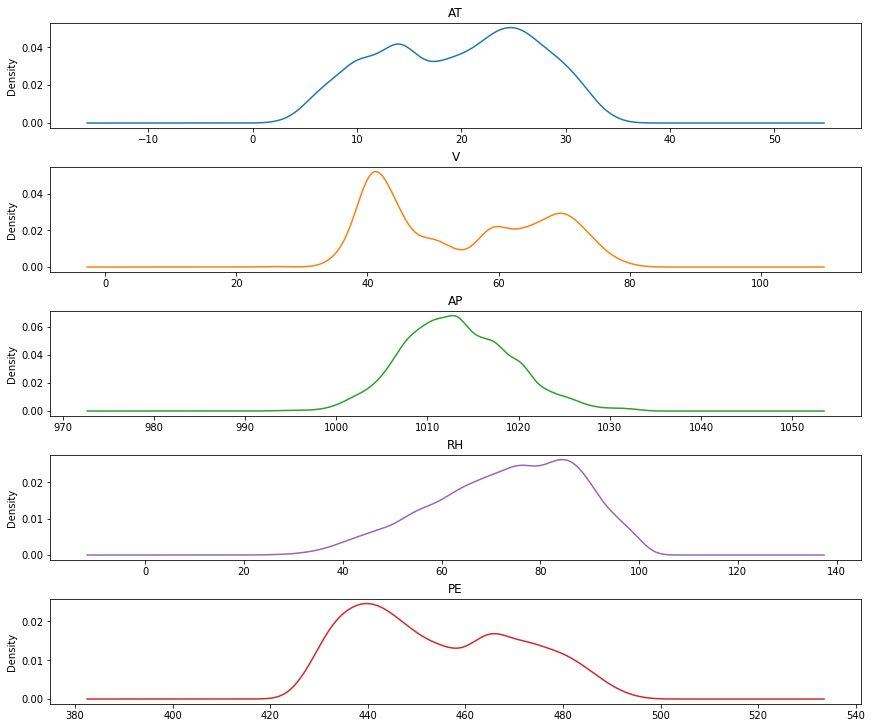

In [12]:
# KDE
fig, axes = plt.subplots(5, 1, figsize=(12, 10), constrained_layout=True)

cols = df.columns
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:red']

idx = 0
for col in cols:
    df[col].plot(kind='kde', color=colors[idx], ax=axes[idx])
    axes[idx].set_title(col)
    idx += 1

plt.show()

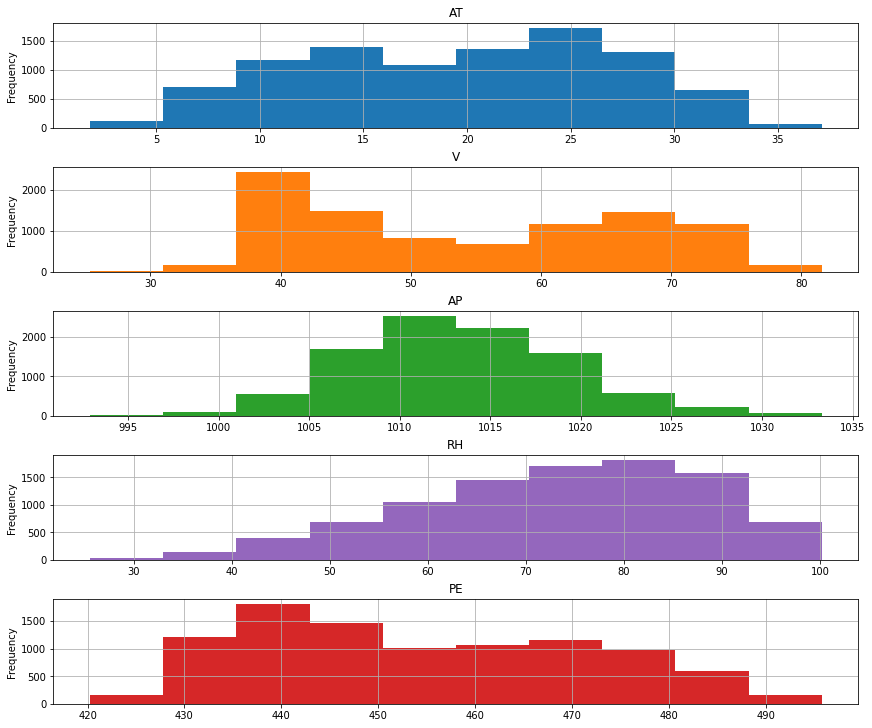

In [13]:
# Histogram
fig, axes = plt.subplots(5, 1, figsize=(12, 10), constrained_layout=True)

cols = df.columns
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:red']

idx = 0
for col in cols:
    df[col].plot(kind='hist', bins=10, grid=True, color=colors[idx], ax=axes[idx])
    axes[idx].set_title(col)
    idx += 1

plt.show()

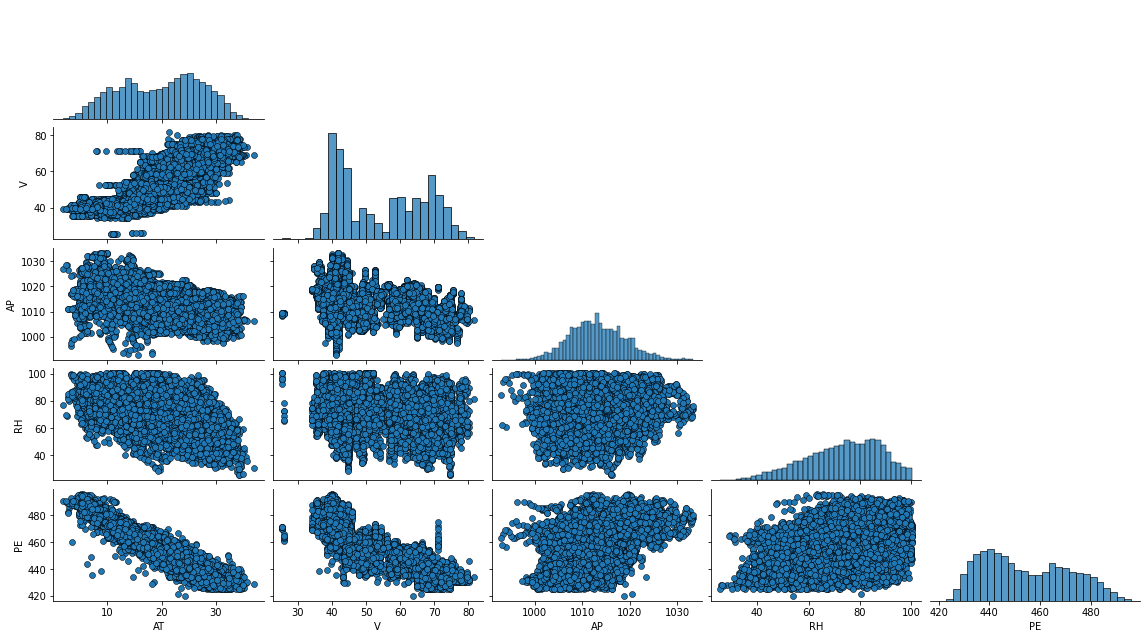

In [14]:
# Pairplot
sns.pairplot(df, height=1.8, aspect=1.8, 
             plot_kws=dict(edgecolor='k', linewidth=0.5),
             corner=True)

#### Correlation Analysis

In [15]:
corr_df = df.corr()

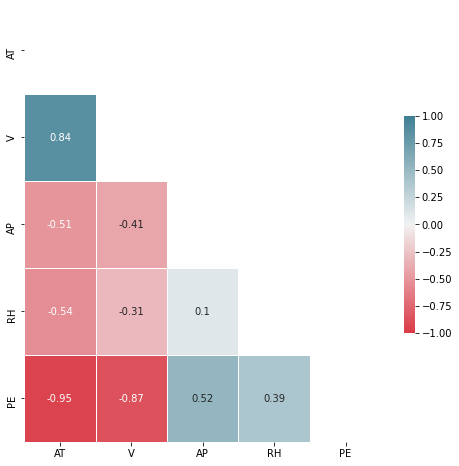

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))

mask = np.zeros_like(corr_df, dtype=bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr_df,
            cmap=cmap,
            annot=True,
            mask=mask,
            linewidths=.9,
            cbar_kws={"shrink":.5},
            vmin=-1,
            vmax=1)
plt.show()

**Correlation between the target variable and independent variables**
* PE and AT: strong negative correlation (-0.95)
* PE and V: strong negative correlation (-0.87)

**Correlation among independent variables**
* AT and V: strong positive correlation (0.84)

AT and V has a strong positive correlation. But as V is only existing control variables, let's keep V for the modelling.

#### Feature Selection

In [17]:
# Multicollinearity remove
# Get a lower triangle of correlation matrix
lower = corr_df.where(np.tril(np.ones(corr_df.shape), k=-1).astype(bool))

# Find columns that have a correlation of 0.95 or higher (absolute values) with other variables.
to_drop = [col for col in lower.columns if any(abs(lower[col]) > 0.95)]

In [18]:
lower

,AT,V,AP,RH,PE
AT,NaN,NaN,NaN,NaN,NaN
V,0.844107,NaN,NaN,NaN,NaN
AP,-0.507549,-0.413502,NaN,NaN,NaN
RH,-0.542535,-0.312187,0.099574,NaN,NaN
PE,-0.948128,-0.869780,0.518429,0.389794,NaN


In [19]:
to_drop

[]

There are no variables to drop becasue of multicollinearity. 

In [20]:
features_selected = ['AT', 'V', 'AP', 'RH']

As we have only four variables, all variables are selected for the prediction.

#### Scaling

In [21]:
# X, y split
feature_names = features_selected
target_name = ['PE']
X = df[feature_names].values
y = np.ravel(df[target_name].values, order='C')

In [22]:
X

array([[  14.96,   41.76, 1024.07,   73.17],
       [  25.18,   62.96, 1020.04,   59.08],
       [   5.11,   39.4 , 1012.16,   92.14],
       ...,
       [  31.32,   74.33, 1012.92,   36.48],
       [  24.48,   69.45, 1013.86,   62.39],
       [  21.6 ,   62.52, 1017.23,   67.87]])

In [23]:
y

array([463.26, 444.37, 488.56, ..., 429.57, 435.74, 453.28])

In [24]:
# Scale values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [25]:
X

array([[0.37252125, 0.29181495, 0.77159119, 0.63820375],
       [0.66203966, 0.66903915, 0.6718634 , 0.44932976],
       [0.09348442, 0.24982206, 0.47686216, 0.8924933 ],
       ...,
       [0.83597734, 0.87135231, 0.49566939, 0.1463807 ],
       [0.64220963, 0.78451957, 0.51893096, 0.49369973],
       [0.56062323, 0.66120996, 0.60232616, 0.56715818]])

In [26]:
y

array([463.26, 444.37, 488.56, ..., 429.57, 435.74, 453.28])

#### Save Preprocessing Objects 

In [27]:
preprocessing_objects_name = 'preprocessing_objects'
created_time = datetime.datetime.now().strftime('%y%m%d_%H%M')
preprocessing_objects_path = os.path.join(base_path, '%s_%s.pkl' % (preprocessing_objects_name, created_time))

preprocessing_objects = {}
preprocessing_objects['scaler'] = scaler
preprocessing_objects['features_selected'] = features_selected

with open(preprocessing_objects_path, 'wb') as handle:
    pickle.dump(preprocessing_objects, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
!ls

CCPP_modeling.ipynb                   background_data_211129_0103.pkl
Folds5x2_pp.xlsx                      preprocessing_objects_211129_0103.pkl
XGB_211129_0103.pkl                   preprocessing_objects_211209_2346.pkl
XGB_explainer_211129_0103.pkl


### Model Test

In [29]:
# Split train, test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=32)

In [30]:
print('X_train: %s, X_test: %s, y_train: %s, y_test: %s' % 
      (str(X_train.shape), str(X_test.shape), str(y_train.shape), str(y_test.shape)))

X_train: (7654, 4), X_test: (1914, 4), y_train: (7654,), y_test: (1914,)


In [31]:
model_results = pd.DataFrame(columns=['model_name', 'cv_scores_mean', 'cv_scores_std', 'test_score', 'model_path'])

In [32]:
# Create a background data for a shap explainer
background_data = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
# Save the background data 
background_data_path = os.path.join(base_path, 'background_data_%s.pkl' % created_time)
with open(background_data_path, 'wb') as handle:
    pickle.dump(background_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
def generate_shap_explainer(model, model_type, background_data):
    if model_type == 'linear':
        explainer = shap.LinearExplainer(model, background_data)
    elif model_type == 'tree':
        explainer = shap.TreeExplainer(model, background_data)
    elif model_type == 'neural-network':
        explainer = shap.DeepExplainer(model, background_data)
    else:
        explainer = shap.KernelExplainer(model.predict, background_data)

    return explainer

In [34]:
def compile_model_info(train, train_labels, test, test_labels, model, model_name, output_path, lib, explainer):
    # Calculate cv scores
    if lib == 'keras':
        cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=32)
        cv_scores = []
        for train_ix, test_ix in cv.split(train):
            cv_train, cv_test = train[train_ix], train[test_ix]
            cv_train_labels, cv_test_labels = train_labels[train_ix], train_labels[test_ix]
            cv_model = create_simple_nn_model(n_inputs, n_outputs)  # Need generalization.
            cv_model.fit(cv_train, cv_train_labels, verbose=0, epochs=100)
            score = cv_model.evaluate(cv_test, cv_test_labels, verbose=0)
            print('> CV MAE: %.3f' % score)
            cv_scores.append(score)
        cv_mean = np.mean(cv_scores)
        cv_std = np.std(cv_scores)
    else:
        cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=32)
        cv_scores = abs(cross_val_score(model, train, train_labels, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1))    
        cv_mean = np.mean(cv_scores)
        cv_std = np.std(cv_scores)
    
    # Calculate test score
    y_pred = model.predict(test)
    test_score = mean_absolute_error(y_pred, test_labels)
    
    # Save a model
    created_time = datetime.datetime.now().strftime('%y%m%d_%H%M')
    if lib == 'keras':
        model_path = os.path.join(output_path, '%s_%s.h5' % (model_name, created_time))
        model.save(model_path)
    else:
        model_path = os.path.join(output_path, '%s_%s.pkl' % (model_name, created_time))
        with open(model_path, 'wb') as handle:
            pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    # Save a explainer
    if lib == 'keras':
        # TODO: Find a way to save a DeepExplainer (if not, a DeepExplainer should be built for every api call.)
        explainer_path = 'NA'
    else:
        explainer_path = os.path.join(output_path, '%s_explainer_%s.pkl' % (model_name, created_time))
        with open(explainer_path, 'wb') as handle:
            pickle.dump(explainer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Compile results
    result = pd.DataFrame({'model_name': model_name, 
                           'cv_scores_mean': cv_mean, 'cv_scores_std': cv_std,
                           'test_score': test_score,
                           'model_path': model_path,
                           'explainer_path': explainer_path}, index=[0])
    
    return result
        

In [35]:
def predict_sample(sample, actual, model):
    y_pred_sample = model.predict(sample.reshape(1, -1))[0]
    y_test_sample = actual
    
    return y_pred_sample, y_test_sample

In [36]:
def explain_model_prediction(data, model_type, shap_explainer, feature_names):
    if model_type == 'neural-network':
        shap_values = shap_explainer.shap_values(data)
        p = shap.force_plot(shap_explainer.expected_value[0], shap_values[0][0], feature_names=feature_names)

    else:
        shap_values = shap_explainer.shap_values(data)
        p = shap.force_plot(shap_explainer.expected_value, shap_values[0], feature_names=feature_names)
        
    return p, shap_values

#### Linear Regression

In [37]:
# Configure a model
model_name = 'LR'
model_type = 'linear'
lib = 'sklearn'
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [38]:
# Create a Explainer
shap_explainer = generate_shap_explainer(model, model_type, background_data)

In [39]:
# Calculate cross validation scores and test score
model_info = compile_model_info(X_train, y_train, X_test, y_test, model, model_name, base_path, lib, shap_explainer)
print('Cross Validation MAE: %.3f (with std: %.3f)' % (model_info['cv_scores_mean'], model_info['cv_scores_std']))
print('Test MAE: %.3f' % model_info['test_score'])
model_results = model_results.append(model_info, ignore_index=True)

# Predict a sample input
sample = X_test[0].reshape(1, -1)
actual = y_test[0]
y_pred_sample, y_test_sample = predict_sample(sample, actual, model)
print('Sample prediction: %.3f, Sample actual: %.3f' % (y_pred_sample, y_test_sample))

Cross Validation MAE: 3.634 (with std: 0.050)
Test MAE: 3.596
Sample prediction: 470.336, Sample actual: 458.740


In [40]:
# Draw a force plot of a sample input.
p, shap_values = explain_model_prediction(X_test[:1], model_type, shap_explainer, feature_names)
p

#### K Neighbors Regressor

In [41]:
# Configure a model
model_name = 'KNNR'
lib = 'sklearn'
model_type = 'knn'
model = KNeighborsRegressor()
model.fit(X_train, y_train)

KNeighborsRegressor()

In [42]:
# Create a Explainer
shap_explainer = generate_shap_explainer(model, model_type, background_data)

In [43]:
# Calculate cross validation scores and test score
model_info = compile_model_info(X_train, y_train, X_test, y_test, model, model_name, base_path, lib, shap_explainer)
print('Cross Validation MAE: %.3f (with std: %.3f)' % (model_info['cv_scores_mean'], model_info['cv_scores_std']))
print('Test MAE: %.3f' % model_info['test_score'])
model_results = model_results.append(model_info, ignore_index=True)

# Predict a sample input
sample = X_test[0].reshape(1, -1)
actual = y_test[0]
y_pred_sample, y_test_sample = predict_sample(sample, actual, model)
print('Sample prediction: %.3f, Sample actual: %.3f' % (y_pred_sample, y_test_sample))

Cross Validation MAE: 2.817 (with std: 0.073)
Test MAE: 2.695
Sample prediction: 469.414, Sample actual: 458.740


In [44]:
# Draw a force plot of a sample input.
p, shap_values = explain_model_prediction(X_test[:1], model_type, shap_explainer, feature_names)
p

  0%|          | 0/1 [00:00<?, ?it/s]

#### Decision Tree Regressor

In [45]:
# Configure a model
model_name = 'DTR'
lib = 'sklearn'
model_type = 'tree'
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [46]:
# Create a Explainer
shap_explainer = generate_shap_explainer(model, model_type, background_data)

In [47]:
# Calculate cross validation scores and test score
model_info = compile_model_info(X_train, y_train, X_test, y_test, model, model_name, base_path, lib, shap_explainer)
print('Cross Validation MAE: %.3f (with std: %.3f)' % (model_info['cv_scores_mean'], model_info['cv_scores_std']))
print('Test MAE: %.3f' % model_info['test_score'])
model_results = model_results.append(model_info, ignore_index=True)

# Predict a sample input
sample = X_test[0].reshape(1, -1)
actual = y_test[0]
y_pred_sample, y_test_sample = predict_sample(sample, actual, model)
print('Sample prediction: %.3f, Sample actual: %.3f' % (y_pred_sample, y_test_sample))

Cross Validation MAE: 3.224 (with std: 0.095)
Test MAE: 3.015
Sample prediction: 461.160, Sample actual: 458.740


In [48]:
# Draw a force plot of a sample input.
p, shap_values = explain_model_prediction(X_test[:1], model_type, shap_explainer, feature_names)
p

#### Support Vector Regressor

In [49]:
# Configure a model
model_name = 'SVR'
lib = 'sklearn'
model_type = 'svm'
model = SVR()
model.fit(X_train, y_train)

SVR()

In [50]:
# Create a Explainer
shap_explainer = generate_shap_explainer(model, model_type, background_data)

In [51]:
# Calculate cross validation scores and test score
model_info = compile_model_info(X_train, y_train, X_test, y_test, model, model_name, base_path, lib, shap_explainer)
print('Cross Validation MAE: %.3f (with std: %.3f)' % (model_info['cv_scores_mean'], model_info['cv_scores_std']))
print('Test MAE: %.3f' % model_info['test_score'])
model_results = model_results.append(model_info, ignore_index=True)

# Predict a sample input
sample = X_test[0].reshape(1, -1)
actual = y_test[0]
y_pred_sample, y_test_sample = predict_sample(sample, actual, model)
print('Sample prediction: %.3f, Sample actual: %.3f' % (y_pred_sample, y_test_sample))

Cross Validation MAE: 3.182 (with std: 0.031)
Test MAE: 3.178
Sample prediction: 469.821, Sample actual: 458.740


In [52]:
# Draw a force plot of a sample input.
p, shap_values = explain_model_prediction(X_test[:1], model_type, shap_explainer, feature_names)
p

  0%|          | 0/1 [00:00<?, ?it/s]

#### Random Forest Regressor

In [53]:
# Configure a model
model_name = 'RFR'
lib = 'sklearn'
model_type ='tree'
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [54]:
# Create a Explainer
shap_explainer = generate_shap_explainer(model, model_type, background_data)

In [55]:
# Calculate cross validation scores and test score
model_info = compile_model_info(X_train, y_train, X_test, y_test, model, model_name, base_path, lib, shap_explainer)
print('Cross Validation MAE: %.3f (with std: %.3f)' % (model_info['cv_scores_mean'], model_info['cv_scores_std']))
print('Test MAE: %.3f' % model_info['test_score'])
model_results = model_results.append(model_info, ignore_index=True)

# Predict a sample input
sample = X_test[0].reshape(1, -1)
actual = y_test[0]
y_pred_sample, y_test_sample = predict_sample(sample, actual, model)
print('Sample prediction: %.3f, Sample actual: %.3f' % (y_pred_sample, y_test_sample))

Cross Validation MAE: 2.465 (with std: 0.060)
Test MAE: 2.301
Sample prediction: 463.370, Sample actual: 458.740


In [56]:
# Draw a force plot of a sample input.
p, shap_values = explain_model_prediction(X_test[:1], model_type, shap_explainer, feature_names)
p

#### XGBoost Regressor

In [57]:
# Configure a model
model_name = 'XGB'
lib = 'xgboost'
model_type = 'tree'
model = xgboost.XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [58]:
# Create a Explainer
shap_explainer = generate_shap_explainer(model, model_type, background_data)

In [59]:
# Calculate cross validation scores and test score
model_info = compile_model_info(X_train, y_train, X_test, y_test, model, model_name, base_path, lib, shap_explainer)
print('Cross Validation MAE: %.3f (with std: %.3f)' % (model_info['cv_scores_mean'], model_info['cv_scores_std']))
print('Test MAE: %.3f' % model_info['test_score'])
model_results = model_results.append(model_info, ignore_index=True)

# Predict a sample input
sample = X_test[0].reshape(1, -1)
actual = y_test[0]
y_pred_sample, y_test_sample = predict_sample(sample, actual, model)
print('Sample prediction: %.3f, Sample actual: %.3f' % (y_pred_sample, y_test_sample))

Cross Validation MAE: 2.338 (with std: 0.075)
Test MAE: 2.172
Sample prediction: 461.536, Sample actual: 458.740


In [60]:
# Draw a force plot of a sample input.
p, shap_values = explain_model_prediction(X_test[:1], model_type, shap_explainer, feature_names)
p

In [61]:
feature_names

['AT', 'V', 'AP', 'RH']

In [62]:
X_test[:1]

array([[0.33909348, 0.26049822, 0.63078446, 0.57788204]])

In [63]:
scaler.inverse_transform(X_test[:1])

array([[  13.78,   40.  , 1018.38,   68.67]])

#### Simple 2-Layers Neural Network

In [64]:
def create_simple_nn_model(n_inputs, n_outputs):
    model = keras.Sequential()
    model.add(layers.Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(layers.Dense(n_outputs, activation='linear'))
    model.compile(loss='mae', optimizer='adam')
    
    model.summary()
    
    return model

In [65]:
# Configure a model
model_name = 'Simple-NN'
lib = 'keras'
model_type = 'neural-network'
n_inputs = X_train.shape[1]
n_outputs = 1
model = create_simple_nn_model(n_inputs, n_outputs)
model.fit(X_train, y_train, verbose=0, epochs=100)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                100       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


2021-12-09 23:46:49.665834: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [66]:
# Create a Explainer
shap_explainer = generate_shap_explainer(model, model_type, background_data)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


In [67]:
# Calculate cross validation scores and test score
model_info = compile_model_info(X_train, y_train, X_test, y_test, model, model_name, base_path, lib, shap_explainer)
print('Cross Validation MAE: %.3f (with std: %.3f)' % (model_info['cv_scores_mean'], model_info['cv_scores_std']))
print('Test MAE: %.3f' % model_info['test_score'])
model_results = model_results.append(model_info, ignore_index=True)

# Predict a sample input
sample = X_test[0].reshape(1, -1)
actual = y_test[0]
y_pred_sample, y_test_sample = predict_sample(sample, actual, model)
print('Sample prediction: %.3f, Sample actual: %.3f' % (y_pred_sample, y_test_sample))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 20)                100       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


> CV MAE: 8.808
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 20)                100       
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
> CV MAE: 5.636
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 20)                100       
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                                 
To

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [68]:
# Draw a force plot of a sample input.
p, shap_values = explain_model_prediction(X_test[:1], model_type, shap_explainer, feature_names)
p

#### Summary of the Model Results

In [69]:
model_results[model_results.columns.difference(['model_path', 'explainer_path'])]

,cv_scores_mean,cv_scores_std,model_name,test_score
0,3.634450,0.049750,LR,3.596082
1,2.816564,0.072639,KNNR,2.695496
2,3.223848,0.095115,DTR,3.015146
3,3.182282,0.030808,SVR,3.177729
4,2.465324,0.059715,RFR,2.301387
5,2.337799,0.074828,XGB,2.171946
6,7.620008,2.376498,Simple-NN,6.454638


In [70]:
model_results_chart = model_results.set_index('model_name')

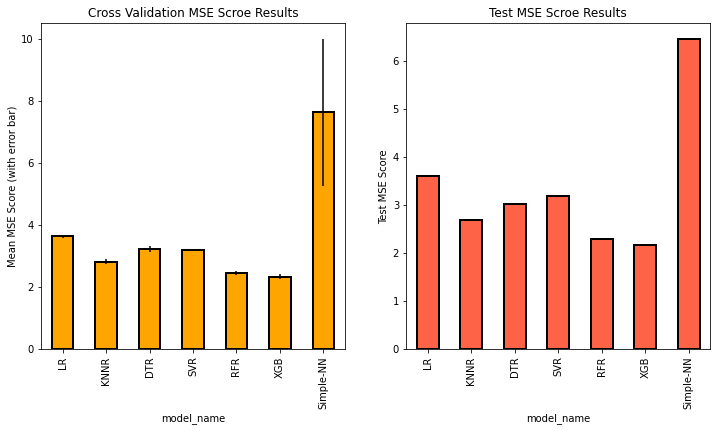

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Cross validations score chart
model_results_chart['cv_scores_mean'].plot.bar(color='orange',
                                               yerr=list(model_results_chart['cv_scores_std']),
                                               edgecolor='k', linewidth=2, ax=axes[0])
axes[0].set_title('Cross Validation MSE Scroe Results')
axes[0].set_ylabel('Mean MSE Score (with error bar)')

# Test score chart
model_results_chart['test_score'].plot.bar(color='tomato',
                                           edgecolor='k', linewidth=2, ax=axes[1])
axes[1].set_title('Test MSE Scroe Results')
axes[1].set_ylabel('Test MSE Score')

plt.show()

#### Load best model from the pickle file

In [72]:
def load_model(model_path):
    _, file_type = model_path.split('.')
    if file_type == 'pkl':
        with open(model_path, 'rb') as handle:
            model = pickle.load(handle)
    elif file_type == 'h5':
        model = keras.models.load_model(model_path)
        
    return model

In [73]:
model_results_sorted = model_results.sort_values(by=['test_score'], axis=0, ascending=True).reset_index(drop=True)

In [74]:
model_results_sorted[model_results_sorted.columns.difference(['model_path', 'explainer_path'])]

,cv_scores_mean,cv_scores_std,model_name,test_score
0,2.337799,0.074828,XGB,2.171946
1,2.465324,0.059715,RFR,2.301387
2,2.816564,0.072639,KNNR,2.695496
3,3.223848,0.095115,DTR,3.015146
4,3.182282,0.030808,SVR,3.177729
5,3.634450,0.049750,LR,3.596082
6,7.620008,2.376498,Simple-NN,6.454638


In [75]:
best_model_path = model_results_sorted.iloc[0, :]['model_path']

In [76]:
with open(best_model_path, 'rb') as handle:
    best_model = pickle.load(handle)

In [77]:
best_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### TODO List

* Hyperparameter optimization
* Add training history charts